In [39]:
# script to read in awas data for flights 5 - 14
# BL TREATMENT - remove samples that are within ~17 km of guam 
# date created: 2/14/2020
# author: sofia chelpon

In [1]:
import xarray as xr
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
### ---------------------- READ IN DATA  ---------------------- ###
# path to data
mypath = '/Volumes/scdrive2/contrast_merge_data/contrast_toga_merge/*.nc'
# read in merge all flights 
contrast_init = xr.open_mfdataset(mypath, combine='by_coords')

In [3]:
# change coordinate from "Time" to "Time_UTC"
contrast_init.assign_coords({'Time': contrast_init.Time_UTC.values})
contrast_init.Time.values[640]

numpy.datetime64('2014-01-25T00:14:06.000000000')

In [4]:
### --- desired toga tracers
# empyt dataset to fill with toga data (12 total)
toga_trc_prelim = xr.merge([contrast_init.Acetaldehyde, contrast_init.n_Butane, 
                     contrast_init.i_Butane, contrast_init.Benzene, 
                     contrast_init.C3H8, contrast_init.Methanol,
                     contrast_init.Bromoform, contrast_init.Tetrachloroethylene,  
                     contrast_init.Dibromomethane,  contrast_init.Dichloromethane, 
                     contrast_init.Chloroform, contrast_init.Carbon_Tetrachloride])
print(len(toga_trc_prelim))

### --- aircraft parameters and location 
toga_param_init = xr.merge([contrast_init.GGALT, contrast_init.GGLAT, contrast_init.GGLON, 
                           contrast_init.Time_UTC, contrast_init.WIC])
                      #contrast_init.WIC, contrast_init.PALT, contrast_init.RHUM])

12


In [12]:
studyarea = np.where((toga_param_init.GGLAT.values > 0) & (toga_param_init.GGLAT.values < 25))


//anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
//anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [19]:
### ---------------------- CONFINE TO NH  ---------------------- ###
# find NH values, what we want 
studyarea = np.where((toga_param_init.GGLAT.values > 0) & (toga_param_init.GGLAT.values < 25))
print(np.size(studyarea))

# keep only NH values, rewrite to toga_param - AIRCRAFT PARAMETERS
toga_param_noblcorr = xr.Dataset()
for ii in toga_param_init.data_vars:
    param = toga_param_init[ii]
    nh_only = param[studyarea].values 
    toga_param_noblcorr[ii] = nh_only
toga_param_noblcorr

# select NH only for all - TRACERS 
toga_trc_nh_noreplace = xr.Dataset()
for ii in toga_trc_prelim.data_vars:
    trc = toga_trc_prelim[ii]
    nh_only = trc[studyarea]
    toga_trc_nh_noreplace[ii] = nh_only


2229


//anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
### ---------------------- APPLY DETECTION LIMIT SUBSTITUTION TO TRC ---------------------- ###
# make attribute for detection level 
toga_lods = [5, 0.5, 0.5, 1, 10, 20, 0.1, 0.3, 0.03, 1, 1, 1];

for ii in enumerate(toga_trc_nh_noreplace.data_vars):
    myind = ii[0]
    trc = ii[1]
    toga_trc_nh_noreplace[trc].attrs['LOD'] = toga_lods[myind]

### --- replace all LLOD/ULOD (-888, -777) with 1/2 the LOD for each tracer 
toga_trc_pre_blcorr = xr.Dataset()    
for ii in toga_trc_nh_noreplace.data_vars:
    # get this tracer and its LOD 
    trc_vals = toga_trc_nh_noreplace[ii].values
    trc = toga_trc_nh_noreplace[ii]
    
    # -------- locations for fills
    # llod 
    llod = trc.attrs['LLOD']
    where_llod = np.where(trc_vals == llod)
    # ulod 
    ulod = trc.attrs['ULOD']
    where_ulod = np.where(trc_vals == ulod)
    
    # -------- make those locations equal to LOD/2 
    trc_vals[where_llod] = trc.LOD/2
    trc_vals[where_ulod] = trc.LOD/2
    # replace values in Dataarray with that including substituded values, save to var 
    trc.values = trc_vals
    toga_trc_pre_blcorr[ii] = trc
    print(np.nanmax(toga_trc_pre_blcorr[ii]))

4121.9
1899.86
785.37
116.38
513.0
4712.0
2.361
3.01
1.742
96.29
19.21
102.0


In [21]:
### ---------------------- ADD LIFETIMES AS AN ATTRIBUTE ---------------------- ###
# read in from xls file to make dataframe
mypath2 = '/Volumes/scdrive2/TTS_2020/contrast_readin/toga_lodhalf/toga_lifetimes_12162019.xlsx'
toga_lifetimes = pd.read_excel(mypath2)

# add attribute to each tracer 
for ii in enumerate(toga_trc_pre_blcorr.data_vars):
    myind = ii[0]
    trc = ii[1]
    toga_trc_pre_blcorr[trc].attrs['BL_lifetime'] = toga_lifetimes['BL_tau'][myind]
    toga_trc_pre_blcorr[trc].attrs['UT_lifetime'] = toga_lifetimes['UT_tau'][myind]
    toga_trc_pre_blcorr[trc].attrs['TROPO_lifetime'] = toga_lifetimes['TROPO_tau'][myind]

In [22]:
### ---------------------- REMOVE BL SAMPLES NEAR GUAM ---------------------- ###
# ~111 km/degree lat and ~108 km/degree long
# so this is about 11 km around guam 
# https://www.johndcook.com/how_big_is_a_degree.html
guam_coord = [13.4, 144.8]
cut = 0.16
print((111*0.16), (108*0.16))
guam_lat_cuts = [guam_coord[0]-cut, guam_coord[0]+cut]
guam_lon_cuts = [guam_coord[1]-cut, guam_coord[1]+cut]

# get the regions near guam to mask out and altitudes (not BL)
null_lat = np.where((toga_param_noblcorr.GGLAT > guam_lat_cuts[0]) 
                    & (toga_param_noblcorr.GGLAT < guam_lat_cuts[1]))
null_lon = np.where((toga_param_noblcorr.GGLON > guam_lon_cuts[0]) 
                    & (toga_param_noblcorr.GGLON < guam_lon_cuts[1]))
null_alt = np.where((toga_param_noblcorr.GGALT < 4000))

# get intersection, index list to mask 
near_guam = np.intersect1d(null_lat, null_lon, null_alt)

# get the opposite of that index, NOT near guam 
#not_guam = np.arange(0, len(toga_param.GGALT.values), dtype = float)
#not_guam[near_guam]=np.nan

not_guam = np.arange(0, len(toga_param_noblcorr.GGALT.values))
not_guam = np.delete(not_guam, near_guam)

17.76 17.28


In [23]:
# keep only non-guam values - AIRCRAFT PARAM 
toga_param = xr.Dataset()
for ii in toga_param_noblcorr.coords:
    param = toga_param_noblcorr[ii]
    param_noguam = param[not_guam].values 
    toga_param[ii] = param_noguam

# keep only non-guam values - TRACERS 
toga_trc = xr.Dataset()
for ii in toga_trc_pre_blcorr.data_vars:
    trc = toga_trc_pre_blcorr[ii]
    trc_noguam = trc[not_guam]
    toga_trc[ii] = trc_noguam
    print(np.nanmax(toga_trc[ii]))

537.8
152.01
88.04
92.2
513.0
1233.0
1.638
3.01
1.742
93.0
16.94
102.0


In [24]:
### ---------------------- ADD AC PARAMETERS AS COORDINATES ---------------------- ###
for ii in toga_param.coords:
    my_coord = toga_param[ii]
    toga_trc.coords[ii] = my_coord

<xarray.DataArray 'GGALT' (GGALT: 0)>
array([], dtype=float32)
Coordinates:
  * GGALT    (GGALT) float32  <xarray.DataArray 'GGLAT' (GGLAT: 0)>
array([], dtype=float32)
Coordinates:
  * GGLAT    (GGLAT) float32  <xarray.DataArray 'GGLON' (GGLON: 0)>
array([], dtype=float32)
Coordinates:
  * GGLON    (GGLON) float32 


//anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


<xarray.Dataset>
Dimensions:               (GGALT: 2174, GGLAT: 2174, GGLON: 2174, Time: 2174, Time_UTC: 2174, WIC: 2174)
Coordinates:
  * Time                  (Time) datetime64[ns] 2014-01-17T00:18:06 ... 2014-02-22T09:20:05
  * GGALT                 (GGALT) float32 3127.166 4212.603 ... 3358.9587
  * GGLAT                 (GGLAT) float32 13.379817 13.258845 ... 12.707678
  * GGLON                 (GGLON) float32 144.9935 145.1362 ... 144.72903
  * Time_UTC              (Time_UTC) datetime64[ns] 2014-01-17T00:18:24 ... 2014-02-22T09:20:23
  * WIC                   (WIC) float32 0.15899388 -0.41373205 ... 0.15925232
Data variables:
    Acetaldehyde          (Time) float32 191.2 126.8 nan 116.9 ... nan nan nan
    n_Butane              (Time) float32 1.51 1.68 1.42 1.14 ... nan nan nan nan
    i_Butane              (Time) float32 2.49 2.6 2.17 1.09 ... nan nan nan nan
    Benzene               (Time) float32 nan nan 7.28 8.23 ... nan nan nan nan
    C3H8                  (Time) float32

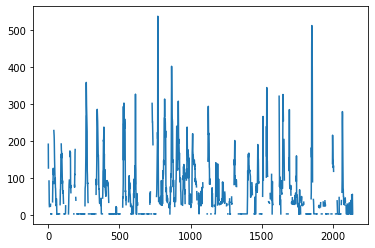

In [25]:
big = np.where(toga_trc.Acetaldehyde.values > 1000)
plt.plot(toga_trc.Acetaldehyde)
print(toga_trc.GGALT[big], toga_trc.GGLAT[big], toga_trc.GGLON[big])

toga_trc

In [26]:
### pickle it! 
toga_trc.to_netcdf(path = '/Volumes/scdrive2/TTS_2020/contrast_readin/toga_lodhalf/toga_trace_gases_twp.nc')
print ('finished saving tracers')

finished saving tracers
